In [93]:
import numpy as mp
import pandas as pd
import math as m
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# lectura de los datos
data = pd.read_csv('../dataNuse/short.csv', sep=',', encoding='utf-8', error_bad_lines=False)

In [ ]:
# agregación de columnas y filtrado de los datos nulos
def data_crime(df):
    
    dfo = df[ ((df['COD_UPZ'] !=  'ND')  & (df['COD_UPZ']  != 'UPZ999'))]
    dfo['JORN'] = pd.to_datetime(dfo['FECHA']).dt.hour//6
    dfo['DSEM'] = pd.to_datetime(dfo['FECHA']).dt.dayofweek
    dfo['ESDIA'] = [0 if (x==0 or x==3) else 1 for x in dfo['JORN']]
    dfo['NSEM'] = pd.to_datetime(dfo['FECHA']).dt.week
    dfo['FSEM'] = [0 if x<4 else 1 for x in dfo['DSEM']]
    return dfo

# encontral intervalos ancho de banda
def bw_intervals(mts, long, lat):
    
    lt_min, lt_max, lg_min, lg_max = 0, 0, 0, 0
    
    cearth = 40075           # earth circumference in kmss
    onedeg_km = cearth / 360 # 1 degree to kms 
    mt_km = mts / 1000       # mts to kms
    
    deglt = mt_km / onedeg_km              # convert kms to deglat
    deglg = mt_km / m.cos(m.radians(lat))  # convert kms to deglong
        
    if lat < 0:
        
        lt_min = -deglt + lat 
        lt_max = lat + deglt
    else:
        
        lt_min = lat - deglt   
        lt_max = lat + deglt
    
    if long < 0:
        
        lg_min = -deglg + long
        lg_max = long + deglg
    else:
        
        lg_min = long - deglt   
        lg_max = long + deglt
    
    return [lg_min, lg_max], [lt_min, lt_max] 
    

In [ ]:
# adecuando el conjunto de datos (dataframe principal)
dfp = data_crime(data)

In [27]:
dfp.head(10)

,Unnamed: 0,LONGITUD,LATITUD,FECHA,COD_UPZ,JORN,DSEM,ESDIA,NSEM,FSEM
0,0,-74.136036,4.541922,2014-02-01 22:16:40,UPZ68,3,5,0,5,1
1,1,-74.090799,4.626935,2014-02-01 00:33:37,UPZ107,0,5,0,5,1
2,2,-74.113194,4.746107,2014-02-01 23:18:51,UPZ71,3,5,0,5,1
3,3,-74.137839,4.672305,2014-02-01 22:23:26,UPZ75,3,5,0,5,1
4,4,-74.110462,4.619172,2014-02-01 18:13:11,UPZ43,3,5,0,5,1
5,5,-74.200905,4.628915,2014-02-01 01:46:35,UPZ87,0,5,0,5,1
6,6,-74.093552,4.689109,2014-02-01 21:53:48,UPZ26,3,5,0,5,1
7,7,-74.111469,4.578727,2014-02-01 19:40:36,UPZ39,3,5,0,5,1
8,8,-74.167484,4.578305,2014-02-01 22:25:35,UPZ69,3,5,0,5,1
9,9,-74.179651,4.607761,2014-02-01 20:33:05,UPZ85,3,5,0,5,1


In [90]:
# Tipos de series de tiempo
# mensual = 0, semanal = 1, diario = 2, dia semana = 3, jornada (dia de la semana) = 4
# jornada todos los dias = 5

# t = tipo de serie
# 
def data_time_series(t, mts, p_lg, pt_lt, df):
    
    # encontrando intervalos de ancho de banda
    bwlong, bwlat = bw_intervals(mts, p_lg, pt_lt)
    df.rename(columns={'Unnamed: 0': 'COUNT'}, inplace=True)
    # dataframe filtrado por latitud y longitud
    dff = df[((df['LATITUD'] >= bwlat[0]) & (df['LATITUD'] <= bwlat[1])) & 
             ((df['LONGITUD'] >= bwlong[0]) & (df['LONGITUD'] <= bwlong[1]))]
    # df.sort_values(by='LATITUD', ascending=False)
    
    if t == 0:
        print('es 0') 
    if t == 1:
        dffg = dff.groupby(by=["NSEM"])['COUNT'].count()
        
    return pd.DataFrame(columns=['COUNT'], data=dffg)

In [91]:
dfweek = data_time_series(1, 100, -74.07745119017216, 4.604447520159951, dfp)
dfweek

,COUNT
NSEM,
1,4
2,4
3,8
4,14
5,11
6,18
7,18
8,8
9,14


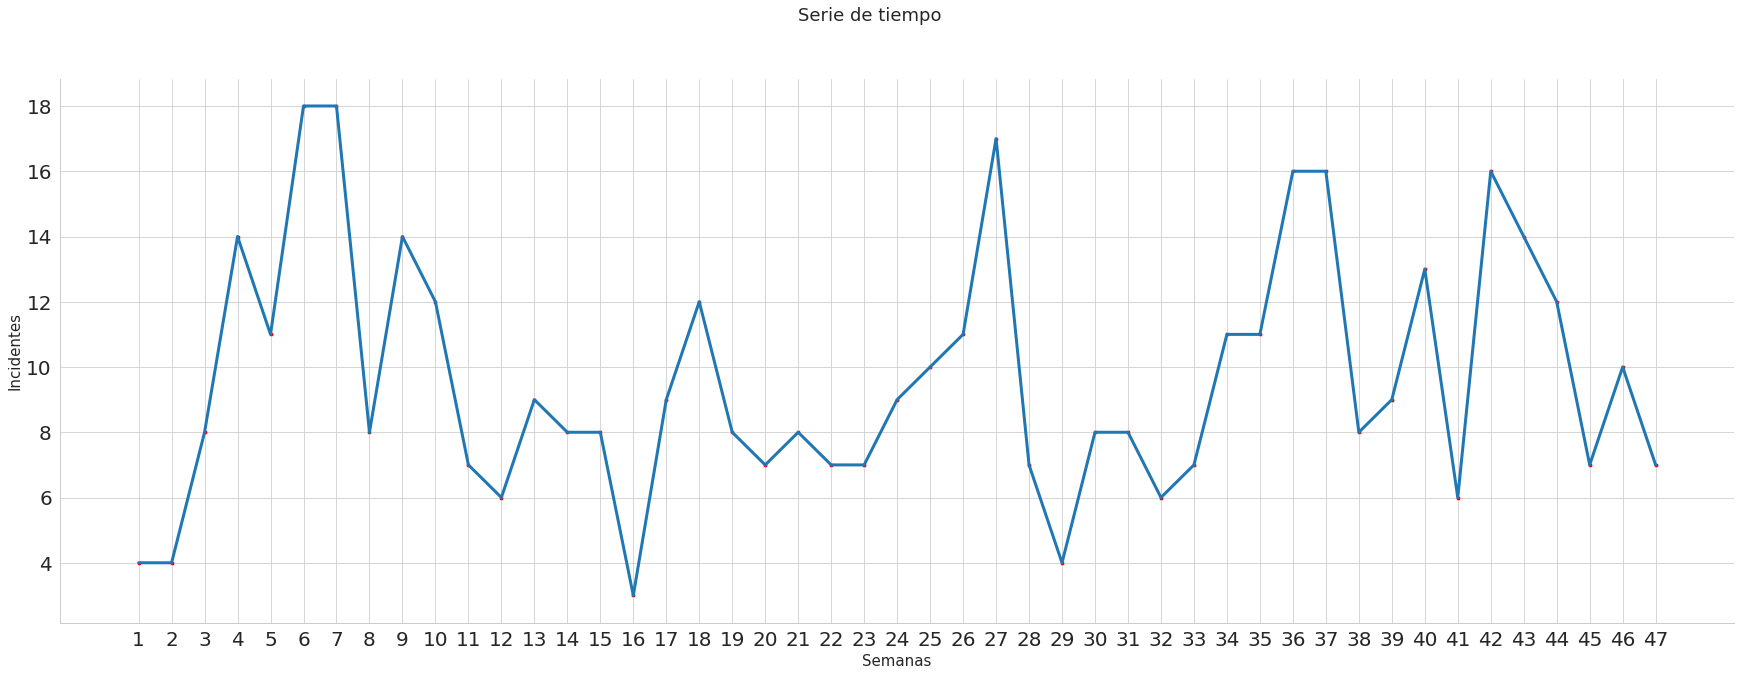

In [113]:
# plot
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(30,10))
fig.suptitle('Serie de tiempo')
sns.set_style("whitegrid")
lp = sns.lineplot(data=dfweek, x=dfweek.index, y='COUNT', linewidth = 3)
sns.scatterplot(data=dfweek, x=dfweek.index, y='COUNT', color='red', sizes=40)
lp.set(xlabel='Semanas', ylabel='Incidentes')
plt.xticks(dfweek.index.to_list(), dfweek.index.to_list(), fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()